In [1]:
import logging
import math
import os
import random
from pathlib import Path
from typing import Iterable, Optional

import numpy as np
import torch

import nncf  # Important - should be imported directly after torch
from nncf import NNCFConfig
from nncf.torch import create_compressed_model, register_default_init_args
from nncf.torch.initialization import PTInitializingDataLoader

import torch.nn.functional as F
import torch.utils.checkpoint

from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from datasets import load_dataset
from diffusers import DiffusionPipeline, StableDiffusionPipeline
from diffusers.optimization import get_scheduler
from huggingface_hub import HfFolder, Repository, whoami
from torchvision import transforms
from tqdm.notebook import tqdm

from itertools import chain

logger = get_logger(__name__)


def get_full_repo_name(model_id: str, organization: Optional[str] = None, token: Optional[str] = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"


dataset_name_mapping = {
    "lambdalabs/pokemon-blip-captions": ("image", "text"),
}


# Adapted from torch-ema https://github.com/fadel/pytorch_ema/blob/master/torch_ema/ema.py#L14
class EMAunet:
    """
    Exponential Moving Average of unets weights
    """

    def __init__(self, parameters: Iterable[torch.nn.Parameter], decay=0.9999):
        parameters = list(parameters)
        self.shadow_params = [p.clone().detach() for p in parameters]

        self.decay = decay
        self.optimization_step = 0

    def get_decay(self, optimization_step):
        """
        Compute the decay factor for the exponential moving average.
        """
        value = (1 + optimization_step) / (10 + optimization_step)
        return 1 - min(self.decay, value)

    @torch.no_grad()
    def step(self, parameters):
        parameters = list(parameters)

        self.optimization_step += 1
        self.decay = self.get_decay(self.optimization_step)

        for s_param, param in zip(self.shadow_params, parameters):
            if param.requires_grad:
                tmp = self.decay * (s_param - param)
                s_param.sub_(tmp)
            else:
                s_param.copy_(param)

        torch.cuda.empty_cache()

    def copy_to(self, parameters: Iterable[torch.nn.Parameter]) -> None:
        """
        Copy current averaged parameters into given collection of parameters.

        Args:
            parameters: Iterable of `torch.nn.Parameter`; the parameters to be
                updated with the stored moving averages. If `None`, the
                parameters with which this `ExponentialMovingAverage` was
                initialized will be used.
        """
        parameters = list(parameters)
        for s_param, param in zip(self.shadow_params, parameters):
            param.data.copy_(s_param.data)

    def to(self, device=None, dtype=None) -> None:
        r"""Move internal buffers of the ExponentialMovingAverage to `device`.

        Args:
            device: like `device` argument to `torch.Tensor.to`
        """
        # .to() on the tensors handles None correctly
        self.shadow_params = [
            p.to(device=device, dtype=dtype) if p.is_floating_point() else p.to(device=device)
            for p in self.shadow_params
        ]

class Args(object):
    pass

args = Args()
args.output_dir = "sd-pokemon-model_quantize"
args.logging_dir = "sd-pokemon-model_quantize"
args.dataset_name = "lambdalabs/pokemon-blip-captions"
logging_dir = os.path.join(args.output_dir, args.logging_dir)

args.train_data_dir = None
args.dataset_config_name = None
args.cache_dir = None
args.gradient_accumulation_steps = 4
args.mixed_precision = "no"
args.report_to = "tensorboard"
args.local_rank = -1
args.seed = None
args.resolution = 512
args.push_to_hub = False
args.center_crop = True
args.random_flip = True
args.train_batch_size=1
args.gradient_checkpointing = True 
args.learning_rate=1e-05
args.max_grad_norm=1
args.lr_scheduler="constant"
args.lr_warmup_steps=0
args.scale_lr = True
args.adam_beta1 = 0.9
args.adam_beta2 = 0.999
args.adam_weight_decay = 1e-2
args.adam_epsilon = 1e-08
args.max_grad_norm = 1.0
args.use_ema = False
args.image_column = "image"
args.caption_column = "text"
args.max_train_samples = 1
args.num_train_epochs = 1
args.use_8bit_adam = False

args.max_train_steps = 1024
args.nncf_init_steps = 300


accelerator = Accelerator(
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision,
    log_with=args.report_to,
    logging_dir=logging_dir,
)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Handle the repository creation
if accelerator.is_main_process:
    if args.push_to_hub:
        if args.hub_model_id is None:
            repo_name = get_full_repo_name(Path(args.output_dir).name, token=args.hub_token)
        else:
            repo_name = args.hub_model_id
        repo = Repository(args.output_dir, clone_from=repo_name)

        with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
            if "step_*" not in gitignore:
                gitignore.write("step_*\n")
            if "epoch_*" not in gitignore:
                gitignore.write("epoch_*\n")
    elif args.output_dir is not None:
        os.makedirs(args.output_dir, exist_ok=True)

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

# Load models and create wrapper for stable diffusion
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder
vae = pipeline.vae
unet = pipeline.unet

# Freeze vae and text_encoder
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Initialize the optimizer
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )

    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW
    
noise_scheduler = pipeline.scheduler

# Get the datasets: you can either provide your own training and evaluation files (see below)
# or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

# In distributed training, the load_dataset function guarantees that only one local process can concurrently
# download the dataset.
if args.dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    dataset = load_dataset(
        args.dataset_name,
        args.dataset_config_name,
        cache_dir=args.cache_dir,
    )
else:
    data_files = {}
    if args.train_data_dir is not None:
        data_files["train"] = os.path.join(args.train_data_dir, "**")
    dataset = load_dataset(
        "imagefolder",
        data_files=data_files,
        cache_dir=args.cache_dir,
    )
    # See more about loading custom images at
    # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

# Preprocessing the datasets.
# We need to tokenize inputs and targets.
column_names = dataset["train"].column_names

# 6. Get the column names for input/target.
dataset_columns = dataset_name_mapping.get(args.dataset_name, None)
if args.image_column is None:
    image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
else:
    image_column = args.image_column
    if image_column not in column_names:
        raise ValueError(
            f"--image_column' value '{args.image_column}' needs to be one of: {', '.join(column_names)}"
        )
if args.caption_column is None:
    caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
else:
    caption_column = args.caption_column
    if caption_column not in column_names:
        raise ValueError(
            f"--caption_column' value '{args.caption_column}' needs to be one of: {', '.join(column_names)}"
        )

# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples, is_train=True):
    captions = []
    for caption in examples[caption_column]:
        if isinstance(caption, str):
            captions.append(caption)
        elif isinstance(caption, (list, np.ndarray)):
            # take a random caption if there are multiple
            captions.append(random.choice(caption) if is_train else caption[0])
        else:
            raise ValueError(
                f"Caption column `{caption_column}` should contain either strings or lists of strings."
            )
    inputs = tokenizer(captions, max_length=tokenizer.model_max_length, padding="do_not_pad", truncation=True)
    input_ids = inputs.input_ids
    return input_ids

train_transforms = transforms.Compose(
    [
        transforms.Resize((args.resolution, args.resolution), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def preprocess_train(examples):
    images = [image.convert("RGB") for image in examples[image_column]]
    examples["pixel_values"] = [train_transforms(image) for image in images]
    examples["input_ids"] = tokenize_captions(examples)

    return examples

with accelerator.main_process_first():
    if args.max_train_samples is not None:
        dataset["train"] = dataset["train"].shuffle(seed=args.seed).select(range(args.max_train_samples))
    # Set the training transforms
    train_dataset = dataset["train"].with_transform(preprocess_train)

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    input_ids = [example["input_ids"] for example in examples]
    padded_tokens = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt")
    return {
        "pixel_values": pixel_values,
        "input_ids": padded_tokens.input_ids,
        "attention_mask": padded_tokens.attention_mask,
    }

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn, batch_size=args.train_batch_size
)


##nncf
weight_dtype = torch.float32

init_data_list = []

for step, batch in enumerate(train_dataloader):
    #print(batch["pixel_values"].shape)
    # Convert images to latent space
    latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
    latents = latents * 0.18215
    #print(latents.shape)

    # Sample noise that we'll add to the latents
    noise = torch.randn_like(latents)
    bsz = latents.shape[0]
    # Sample a random timestep for each image
    timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
    timesteps = timesteps.long()

    # Add noise to the latents according to the noise magnitude at each timestep
    # (this is the forward diffusion process)
    noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
    #print(noisy_latents.shape)
    encoder_hidden_states = text_encoder(batch["input_ids"])[0]
    #print(encoder_hidden_states.shape)
    noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
    #print(noise_pred.shape)
    init_data_list.append((torch.squeeze(noisy_latents), torch.squeeze(timesteps), torch.squeeze(encoder_hidden_states), 0))
    if step >= args.nncf_init_steps:
        break



class MyInitializingDataLoader(PTInitializingDataLoader):

    def get_inputs(self, dataloader_output):
        noisy_latents = dataloader_output[0].float().to("cpu", non_blocking=True)
        timesteps = dataloader_output[1].float().to("cpu", non_blocking=True)
        encoder_hidden_states = dataloader_output[2].float().to("cpu", non_blocking=True)
        return (noisy_latents,timesteps,encoder_hidden_states), {}

    def get_target(self, dataloader_output):
        return dataloader_output[0]


class DummyDataset(torch.utils.data.Dataset):
    def __len__(self): return args.nncf_init_steps
    def __getitem__(self, index): 
        i = index // args.nncf_init_steps
        return init_data_list[i]
    
    
dataloader = torch.utils.data.DataLoader(DummyDataset(), batch_size=1, num_workers=1)
nncf_config_dict = {
    "input_info": [
        {   #"keyword": "latent_model_input",
            "sample_size": [1, 4, 64, 64]
        },
        {   #"keyword": "t",
            "sample_size": [1]
        },
        {   #"keyword": "encoder_hidden_states",
            "sample_size": [1,77,768]
        }
    ],
    "log_dir": args.output_dir,  # The log directory for NNCF-specific logging outputs.
    "compression": 
    {
        "algorithm": "quantization",  # Specify the algorithm here.
        "preset" : "mixed",
        "initializer": {
            "range": {"num_init_samples": args.nncf_init_steps, "type": "mean_min_max"},
            "batchnorm_adaptation": {"num_bn_adaptation_samples": args.nncf_init_steps},
        },
        "scope_overrides": {"activations": {"{re}.*baddbmm_0": {"mode": "symmetric"}}},
        "ignored_scopes": [
            "{re}.*__add___[0-2]",
            "{re}.*layer_norm_0",
            "{re}.*CrossAttention.*/bmm_0",
            "{re}.*__truediv__*",
            "{re}.*group_norm_0",
            "{re}.*mul___[0-2]",
            "{re}.*silu_[0-2]",
        ],
        "export_to_onnx_standard_ops": True
    },
}

optimizer = optimizer_cls(
    unet.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
)
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

nncf_config = NNCFConfig.from_dict(nncf_config_dict)
nncf_config_unet = register_default_init_args(nncf_config, MyInitializingDataLoader(dataloader))
compression_ctrl_unet, unet = create_compressed_model(unet, nncf_config_unet)

statistics_unet = compression_ctrl_unet.statistics()
print(statistics_unet.to_str())

unet.train()

for p in unet.parameters():
    p.requires_grad = False
    
for q in compression_ctrl_unet.all_quantizations.values():
    q.enable_gradients()

# quantizer_parameters = {}
# for q in compression_ctrl_unet.all_quantizations.values():
#     q.enable_gradients()
#     quantizer_parameters += q.parameters()

#quantization_params = [filter(lambda p: p.requires_grad, unet.parameters()) for q in compression_ctrl_unet.all_quantizations.values()]

# Reinitq
optimizer = optimizer_cls(
    #chain(*quantization_params),
    filter(lambda p: p.requires_grad, unet.parameters()),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
    num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
)
unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

# Scheduler and math around the number of training steps.
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if args.max_train_steps is None:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
    overrode_max_train_steps = True



unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    unet, optimizer, train_dataloader, lr_scheduler
)

weight_dtype = torch.float32
if args.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif args.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16

# Move text_encode and vae to gpu.
# For mixed precision training we cast the text_encoder and vae weights to half-precision
# as these models are only used for inference, keeping weights in full precision is not required.
text_encoder.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)



# Create EMA for the unet.
if args.use_ema:
    ema_unet = EMAModel(unet.parameters())

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
if overrode_max_train_steps:
    args.max_train_steps = args.num_train_epochs * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
args.num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("text2image-fine-tune", config=vars(args))


#print(unet)
# Train!
total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {args.num_train_epochs}")
logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
logger.info(f"  Total optimization steps = {args.max_train_steps}")

# Only show the progress bar once on each machine.
progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
progress_bar.set_description("Steps")
global_step = 0

for epoch in range(args.num_train_epochs):
    train_loss = 0.0
    compression_ctrl_unet.scheduler.epoch_step()


    compression_scheduler_unet = compression_ctrl_unet.scheduler
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(unet):
            compression_scheduler_unet.step()

            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"].to(weight_dtype)).latent_dist.sample()
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # Get the text embedding for conditioning
            encoder_hidden_states = text_encoder(batch["input_ids"])[0]
            #print(encoder_hidden_states.shape)

            # Predict the noise residual and compute loss
            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = F.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

            # Gather the losses across all processes for logging (if we use distributed training).
            avg_loss = accelerator.gather(loss.repeat(args.train_batch_size)).mean()
            train_loss += avg_loss.item() / args.gradient_accumulation_steps

            compression_loss_unet = compression_ctrl_unet.loss()
            loss = loss + compression_loss_unet

            # Backpropagate
            accelerator.backward(loss)
            if accelerator.sync_gradients:
                accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        # Checks if the accelerator has performed an optimization step behind the scenes
        if accelerator.sync_gradients:
            if args.use_ema:
                ema_unet.step(unet.parameters())
            progress_bar.update(1)
            global_step += 1
            accelerator.log({"train_loss": train_loss}, step=global_step)
            train_loss = 0.0

        logs = {"step_loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
        progress_bar.set_postfix(**logs)

        if global_step >= args.max_train_steps:
            break
    statistics_unet = compression_ctrl_unet.statistics()

# Create the pipeline using the trained modules and save it.
accelerator.wait_for_everyone()
if accelerator.is_main_process:
    unet = accelerator.unwrap_model(unet)
    if args.use_ema:
        ema_unet.copy_to(unet.parameters())

    # pipeline = StableDiffusionPipeline(
    #     text_encoder=text_encoder,
    #     vae=vae,
    #     unet=unet,
    #     tokenizer=tokenizer,
    #     scheduler=pipeline.scheduler,
    #     safety_checker=pipeline.safety_checker,
    #     feature_extractor=pipeline.feature_extractor,
    # )
    #pipeline.save_pretrained(args.output_dir)
    
    if args.push_to_hub:
        repo.push_to_hub(commit_message="End of training", blocking=False, auto_lfs_prune=True)

accelerator.end_training()





/home/alex/virt_envs/stable_diffusion/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, onnx, openvino


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


[ WARNING ] Found cached dataset parquet (/home/alex/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


[ WARNING ]  Found cached dataset parquet (/home/alex/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:nncf:Not adding activation input quantizer for operation: 20 UNet2DConditionModel/ModuleList[down_blocks]/CrossAttnDownBlock2D[0]/ModuleList[resnets]/ResnetBlock2D[0]/NNCFGroupNorm[norm1]/group_norm_0
21 UNet2DConditionModel/ModuleList[down_blocks]/CrossAttnDownBlock2D[0]/ModuleList[resnets]/ResnetBlock2D[0]/SiLU[nonlinearity]/silu_0

INFO:nncf:Not adding activation input quantizer for operation: 8 UNet2DConditionModel/Timesteps[time_proj]/__mul___0
INFO:nncf:Not adding activation input quantizer for operation: 9 UNet2DConditionModel/Timesteps[time_proj]/__rmul___0
INFO:nncf:Not adding activation input quantizer for operation: 1039 UNet2DConditionModel/ModuleList[up_blocks]/CrossAttnUpBlock2D[2]/ModuleList[resnets]/ResnetBlock2D[2]/SiLU[nonlinearity]/silu_1
INFO:nncf:Not adding activation input quantizer for operation: 1119 UNet2DConditionModel/ModuleList[up_blocks]/CrossAttnUpBlock2D[3]/ModuleList[resnets]/ResnetBlock2D[0]/SiLU[nonlinearity]/silu_1
INFO:nncf:Not adding activation

  0%|          | 0/1024 [00:00<?, ?it/s]

In [2]:
#task = OVStableDiffusionPipeline._auto_model_to_task(OVStableDiffusionPipeline.auto_model_class)
save_dir = "sd_nncf_onnx"
save_dir_path = Path(save_dir)

# unet = unet.cuda(1)
# vae = vae.cuda(1)
# text_encoder = text_encoder.cuda(1)

# unet = unet.cpu()
# vae = unet.cpu()
# text_encoder = text_encoder.cpu()

unet.eval()
vae.eval()
text_encoder.eval()

device = "cuda:0"

sd_pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder.to(device),
    vae=vae.to(device),
    unet = unet.to(device),
    tokenizer=tokenizer,
    scheduler=pipeline.scheduler,
    safety_checker=pipeline.safety_checker.to(device),
    feature_extractor=pipeline.feature_extractor,
)
sd_pipeline = sd_pipeline.to(device)

In [3]:
with torch.no_grad():
    prompt = "sailing ship in storm by Rembrandt"
    #prompt = "plant pokemon in the jungle"
    output = sd_pipeline(prompt, num_inference_steps=50, output_type="pil")

  0%|          | 0/50 [00:00<?, ?it/s]

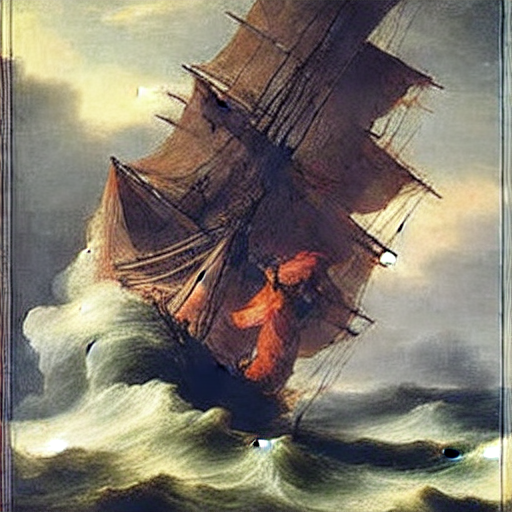

In [4]:
from IPython.display import Image, display

#Image(output.images[0].copy(order='C'))
display(output.images[0])

In [5]:
exp_unet = compression_ctrl_unet.prepare_for_inference(True)

device = "cuda:0"

sd_pipeline = StableDiffusionPipeline(
    text_encoder=text_encoder.to(device),
    vae=vae.to(device),
    #unet=unet.to(device),
    unet = exp_unet.to(device),
    tokenizer=tokenizer,
    scheduler=pipeline.scheduler,
    safety_checker=pipeline.safety_checker.to(device),
    feature_extractor=pipeline.feature_extractor,
)


  0%|          | 0/50 [00:00<?, ?it/s]

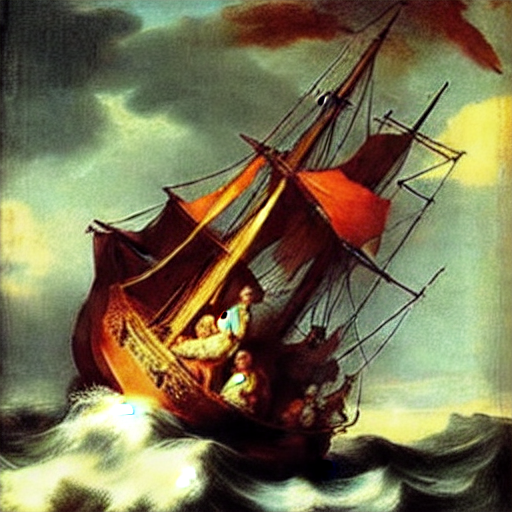

In [9]:
with torch.no_grad():
    output = sd_pipeline(prompt, num_inference_steps=50, output_type="pil")
display(output.images[0])

In [10]:
from optimum.exporters.onnx import export_models, get_stable_diffusion_models_for_export
from optimum.utils import (
    CONFIG_NAME,
    DIFFUSION_MODEL_TEXT_ENCODER_SUBFOLDER,
    DIFFUSION_MODEL_UNET_SUBFOLDER,
    DIFFUSION_MODEL_VAE_DECODER_SUBFOLDER,
    DIFFUSION_MODEL_VAE_ENCODER_SUBFOLDER,
)
from optimum.intel import OVStableDiffusionPipeline

ONNX_WEIGHTS_NAME = "model.onnx"
ONNX_ENCODER_NAME = "encoder_model.onnx"
ONNX_DECODER_NAME = "decoder_model.onnx"
ONNX_DECODER_WITH_PAST_NAME = "decoder_with_past_model.onnx"

output_names = [
    os.path.join(DIFFUSION_MODEL_TEXT_ENCODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_UNET_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_VAE_ENCODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_VAE_DECODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
]

#del models_and_onnx_configs['unet']

save_dir_path = Path("sd_nncf_onnx_alt")

with torch.no_grad():
    models_and_onnx_configs = get_stable_diffusion_models_for_export(sd_pipeline)
    sd_pipeline.save_config(save_dir_path)
    export_models(
        models_and_onnx_configs=models_and_onnx_configs,
        output_dir=save_dir_path,
        output_names=output_names
    )

Using framework PyTorch: 1.13.1+cu116


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper__index_select)

In [ ]:
exp_unet.cpu()
vae.cpu()
text_encoder.cpu()
print("Done")

In [ ]:
from optimum.exporters.onnx import export_models, get_stable_diffusion_models_for_export
from optimum.utils import (
    CONFIG_NAME,
    DIFFUSION_MODEL_TEXT_ENCODER_SUBFOLDER,
    DIFFUSION_MODEL_UNET_SUBFOLDER,
    DIFFUSION_MODEL_VAE_DECODER_SUBFOLDER,
    DIFFUSION_MODEL_VAE_ENCODER_SUBFOLDER,
)
from optimum.intel import OVStableDiffusionPipeline

ONNX_WEIGHTS_NAME = "model.onnx"
ONNX_ENCODER_NAME = "encoder_model.onnx"
ONNX_DECODER_NAME = "decoder_model.onnx"
ONNX_DECODER_WITH_PAST_NAME = "decoder_with_past_model.onnx"

output_names = [
    os.path.join(DIFFUSION_MODEL_TEXT_ENCODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_UNET_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_VAE_ENCODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
    os.path.join(DIFFUSION_MODEL_VAE_DECODER_SUBFOLDER, ONNX_WEIGHTS_NAME),
]

#del models_and_onnx_configs['unet']

save_dir_path = Path("sd_nncf_onnx_alt")

with torch.no_grad():
    models_and_onnx_configs = get_stable_diffusion_models_for_export(sd_pipeline)
    sd_pipeline.save_config(save_dir_path)
    export_models(
        models_and_onnx_configs=models_and_onnx_configs,
        output_dir=save_dir_path,
        output_names=output_names
    )

Using framework PyTorch: 1.13.1+cu116


AttributeError: 'str' object has no attribute 'shape'

### Working export of Unet to multiple files

In [12]:
from torch.utils._pytree import tree_map
import onnx

from optimum.exporters.onnx import export_models, get_stable_diffusion_models_for_export
from optimum.utils import (
    CONFIG_NAME,
    DIFFUSION_MODEL_TEXT_ENCODER_SUBFOLDER,
    DIFFUSION_MODEL_UNET_SUBFOLDER,
    DIFFUSION_MODEL_VAE_DECODER_SUBFOLDER,
    DIFFUSION_MODEL_VAE_ENCODER_SUBFOLDER,
)
from optimum.intel import OVStableDiffusionPipeline

models_and_onnx_configs = get_stable_diffusion_models_for_export(sd_pipeline)
dtype = torch.float16
config = models_and_onnx_configs["unet"][1]
opset = 14
output = Path("sd_nncf_onnx/unet/model.onnx")

device = "cpu"
latent_model_input = (torch.rand([1,4,64,64])).to(device)
t = (torch.rand([1])).to(device)
text_embeddings = torch.rand([1,77,768]).to(device)
exp_unet.to(device)

with torch.no_grad():
    # unet.config.return_dict = True
    # unet.eval()

    # Check if we need to override certain configuration item
    if config.values_override is not None:
        logger.info(f"Overriding {len(config.values_override)} configuration item(s)")
        for override_config_key, override_config_value in config.values_override.items():
            logger.info(f"\t- {override_config_key} -> {override_config_value}")
            setattr(exp_unet.config, override_config_key, override_config_value)

    inputs = config.ordered_inputs(exp_unet)
    input_names = list(inputs.keys())
    output_names = list(config.outputs.keys())

    with config.patch_model_for_export(exp_unet):        
        torch.onnx.export(
            exp_unet,
            (latent_model_input, t, text_embeddings),
            f=output.as_posix(),
            input_names=input_names,
            output_names=output_names,
            do_constant_folding=True,
            opset_version=opset,
            training=torch.onnx.TrainingMode.EVAL,
        )
            
print("Done")

NNCF relies on custom-wrapping the `forward` call in order to function properly.
Arbitrary adjustments to the forward function on an NNCFNetwork object have undefined behaviour.
If you need to replace the underlying forward function of the original model so that NNCF should be using that instead of the original forward function that NNCF saved during the compressed model creation, you can do this by calling:
model.nncf.set_original_unbound_forward(fn)
if `fn` has an unbound 0-th `self` argument, or
with model.nncf.temporary_bound_original_forward(fn): ...
if `fn` already had 0-th `self` argument bound or never had it in the first place.
NNCF relies on custom-wrapping the `forward` call in order to function properly.
Arbitrary adjustments to the forward function on an NNCFNetwork object have undefined behaviour.
If you need to replace the underlying forward function of the original model so that NNCF should be using that instead of the original forward function that NNCF saved during th

In [14]:
import openvino.runtime as ov
from openvino.tools.mo import convert_model

# onnx_model = onnx.load(
#         str(output), load_external_data=True
#     )


ov_model = convert_model(str(output))

print("Converted")

# ov_model = convert_model(onnx_model, 
#                          input = {
#                              "latent_model_input": latent_model_input, 
#                              "t": t, 
#                              "text_embeddings": text_embeddings})

ov.serialize(ov_model, str(output).replace(".onnx", ".xml"))

Error: Unknown model type: <class 'onnx.onnx_ml_pb2.ModelProto'>

In [ ]:
from optimum.onnx.utils import check_model_uses_external_data, _get_onnx_external_data_tensors
FORCE_ONNX_EXTERNAL_DATA = False

onnx_model = onnx.load(str(output), load_external_data=False)
model_uses_external_data = check_model_uses_external_data(onnx_model)

if model_uses_external_data or FORCE_ONNX_EXTERNAL_DATA:
    tensors_paths = _get_onnx_external_data_tensors(onnx_model)
    logger.info("Saving external data to one file...")

    # try free model memory
    del onnx_model

    onnx_model = onnx.load(
        str(output), load_external_data=True
    )  # this will probably be too memory heavy for large models
    onnx.save(
        onnx_model,
        str(output),
        save_as_external_data=True,
        all_tensors_to_one_file=True,
        location=output.name + "_data",
        size_threshold=1024 if not FORCE_ONNX_EXTERNAL_DATA else 0,
    )

    # delete previous external data
    for tensor in tensors_paths:
        os.remove(output.parent / tensor)

ValueError: The proto size is larger than the 2 GB limit. Please use save_as_external_data to save tensors separately from the model file.